# Semantic segmentation model of smoke plumes derived from forest fires as seen from GOES-16 Satellite Imagery

### Importing Necessary Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.nn import functional
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import cv2
import pandas as pd
import time
from torch.cuda import amp

### GPU with CPU

In [3]:
# Check if CUDA is available and select the corresponding device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Initialize the gradient climber
scaler = amp.GradScaler()

cuda


/tmp/ipykernel_30/40379246.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


### Defining Directories

In [4]:
 # We define the base path for our dataset
base_path = os.path.join(os.path.dirname(os.getcwd()), '/kaggle/input/goes16-wildfires-smoke-plumes-dataset/GOES16-wildfires-smoke-plumes-dataset-1da')

 # We define the routes for the training sets and their masks
train_path = os.path.join(base_path, 'train')
train_masks_path = os.path.join(base_path, 'train_masks')

 # We define the routes for the validation sets and their masks
valid_path = os.path.join(base_path, 'valid')
valid_masks_path = os.path.join(base_path, 'valid_masks')

 # We define the routes for the test sets and their masks
test_path = os.path.join(base_path, 'test')
test_masks_path = os.path.join(base_path, 'test_masks')

 # We define the path for the models folder, which will be in the parent directory of the current directory.
models_path = ("/kaggle/working/")

### Dataset y DataLoader

In [5]:
class SmokeDataset(Dataset):
    """
    Class to represent a dataset of images and smoke masks.
    """
    def __init__(self, images, masks=None, img_transforms=None, mask_transforms=None):
        self.images = images
        self.masks = masks
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms

        # Initialize image file lists and masks
        self.image_files = []
        self.mask_files = []

        # If masks are provided, ensure that the number of images and masks matches
        if self.masks is not None:
            assert len(os.listdir(self.images)) == len(os.listdir(self.masks)), 'There are no same number of images and masks'
            # Get sorted list of image files and masks
            self.image_files = sorted(os.listdir(self.images))
            self.mask_files = sorted(os.listdir(self.masks))
        else:
            # Get list of sorted image files
            self.image_files = sorted(os.listdir(self.images))

    def __len__(self):
        """
        Method to get the number of images in the dataset.
        """
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Method to obtain the image and its associated mask at position 'idx'.
        """
        image_name = os.path.join(self.images, self.image_files[idx])
        img = Image.open(image_name)
        # Transform the image to tensor
        trans = transforms.ToTensor()

        # Apply transformations to the image if provided
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        else:
            img = trans(img)

        # If masks are provided, get and transform the mask associated with the image
        if self.masks is not None:
            mask_name = os.path.join(self.masks, self.mask_files[idx])
            mask = Image.open(mask_name)
            # Apply transformations to the mask if provided
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = trans(mask)
            # Normalize the mask
            mask_max = mask.max().item()
            mask /= mask_max
            return img, mask
        else:
            return img

In [6]:
#Define data transformation
transform_data = transforms.Compose([
    transforms.Resize([128, 128]),
    transforms.ToTensor()])

# Create the training dataset
train_dataset = SmokeDataset(train_path, train_masks_path,
                             img_transforms = transform_data,
                             mask_transforms = transform_data)

# Create the validation dataset
val_dataset = SmokeDataset(valid_path, valid_masks_path,
                           img_transforms = transform_data, mask_transforms = transform_data)

# Create the test dataset
test_dataset = SmokeDataset(test_path, test_masks_path, 
                            img_transforms = transform_data, mask_transforms = transform_data)

print(f'Number of Training images: {len(train_dataset)}, Validation: {len(val_dataset)}, Test:{len(test_dataset)}')

Number of Training images: 1462, Validation: 207, Test:123


In [7]:
# Batch Size
batch_size =  32

# Training, validation and testing data loader
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = len(test_dataset), shuffle = True)

print(len(train_loader), len(val_loader), len(test_loader))
print(f'Number of Training mini-batches: {len(train_loader)}, Validation: {len(val_loader)}, Test:{len(test_loader)}')

46 7 1
Number of Training mini-batches: 46, Validation: 7, Test:1


### Example plot

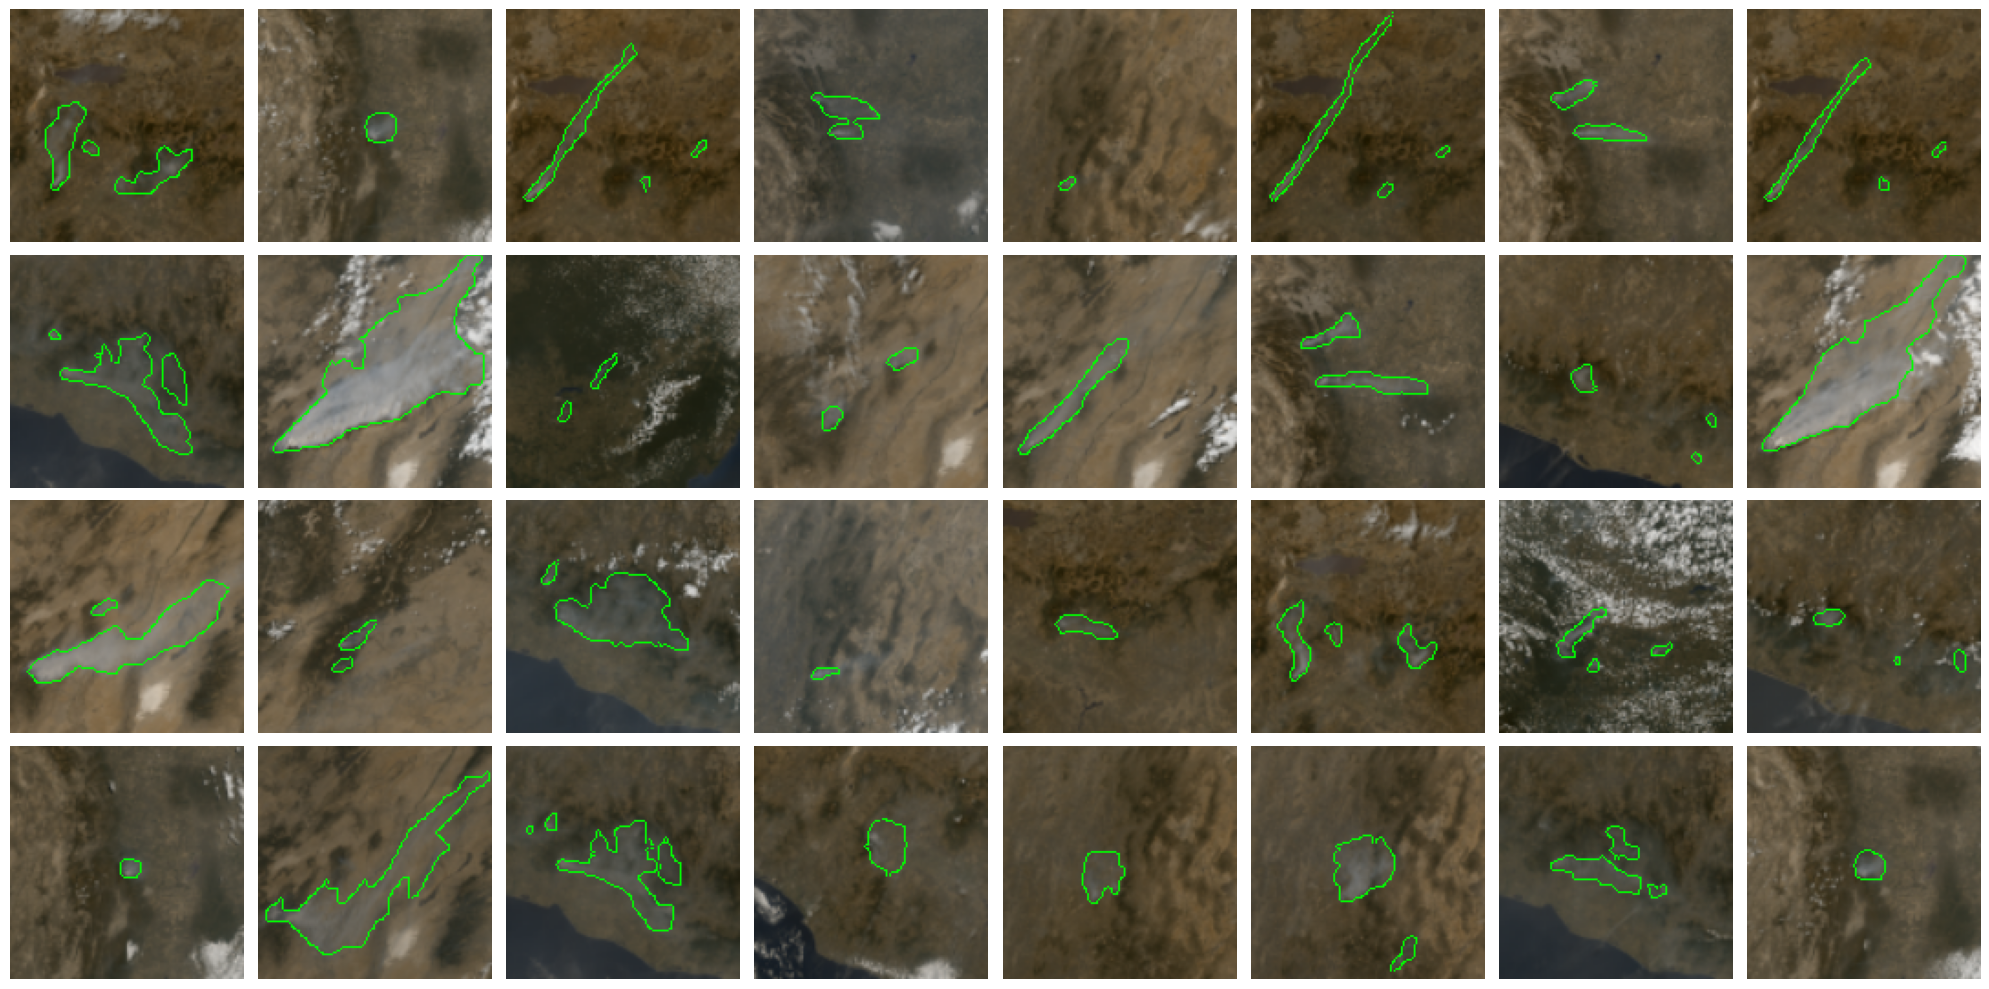

In [9]:
def plot_mini_batch(imgs, masks):
    """
    Function to display a visual representation of a batch of images and their associated masks.

    Parameters:
    imgs (torch.Tensor): Tensor containing a batch of images with dimensions (batch_size, channels, height, width).
    masks (torch.Tensor): Tensor containing a batch of masks with dimensions (batch_size, channels, height, width).

    Returns:
    None

    Example:
    imgs, masks = next(iter(train_loader))
    plot_mini_batch(imgs, masks)
    """
    plt.figure(figsize=(20, 10))
    # Convert images and masks to numpy arrays
    imgs = imgs.permute(0, 2, 3, 1).cpu().numpy()
    masks = masks.permute(0, 2, 3, 1).cpu().numpy()

    for i in range(batch_size):
        plt.subplot(4, 8, i + 1)
        # Get the image and the corresponding mask
        img = imgs[i, ...]
        mask = masks[i, ...]

        # Adjust image values ​​between 0 and 1
        img = np.clip(img, 0, 1)

        # Get the contours of the mask
        contour_mask = cv2.Canny(mask[:, :, 0].astype(np.uint8), 0, 1)
        # Create a copy of the image with the contours highlighted in green
        img_with_contour = img.copy()
        img_with_contour[contour_mask > 0] = [0, 1, 0]

        plt.imshow(img_with_contour)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Get a batch of images and masks from the training set
imgs, masks = next(iter(val_loader))
# Show batch of images and masks
plot_mini_batch(imgs, masks)

### Metrics

In [10]:
def metrics(model, loader):
    """
    Computes accuracy and other evaluation metrics for a given model using a DataLoader.

    Parameters:
    model (torch.nn.Module): The model to evaluate.
    loader (torch.utils.data.DataLoader): DataLoader containing the evaluation data.

    Returns:
    tuple: A tuple containing the following evaluation metrics:
    - val_cost (float): Average cost of the loss function (cross_entropy).
    - val_acc (float): Average accuracy of the model.
    - dice (float): Dice coefficient, a measure of similarity between predictions and actual labels.
    - iou (float): Jaccard index (IoU), another similarity measure for segmentation problems.
    - tp (int): True Positives.
    - tn (int): True Negatives.
    - fp (int): False Positives.
    - fn (int): False Negatives.
    """
    cost = 0.0
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    model = model.to(device=device)
    # Disable gradient calculation during execution of this code block
    with torch.no_grad():
        # Iterate over the loader data
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            with amp.autocast():
                # Calculate the model scores
                scores = model(x)
                # Calculate the cost using the cross entropy loss function
                cost += functional.cross_entropy(scores, y).item()
                # Calculate the model predictions
                preds = torch.max(scores, dim=1)[1]

                # Calculate TP, TN, FP, FN
                tp += ((preds == 1) & (y == 1)).sum().item()
                tn += ((preds == 0) & (y == 0)).sum().item()
                fp += ((preds == 1) & (y == 0)).sum().item()
                fn += ((preds == 0) & (y == 1)).sum().item()

    # Calculate the final metrics
    dice = (2 * tp) / (2 * tp + fp + fn + 1e-8)
    iou = (tp) / (tp + fp + fn + 1e-8)
    acc = (tp + tn) / (tp + tn + fp + fn + 1e-8)
    val_cost = cost / len(loader)
    
    return val_cost, acc, dice, iou, tp, tn, fp, fn

### Training function

In [11]:
# Create empty DataFrame
history_df = pd.DataFrame()

def train(model, optimiser, scheduler = None, epochs = 5, store_every = 1):
    """
    Trains the model using the specified optimizer over a number of epochs.

    Parameters:
    model (torch. nn. Module): The model to train.
    optimiser (torch. optimizer): The optimizer used to update the model weights.
    scheduler (torch. optim. lr_scheduler. _LRScheduler, optional): The learning rate scheduler (LR scheduler).
    By default, this is None, meaning that no learning rate scheduler is used.
    epochs (int, optional): The number of epochs (complete iterations) to train the model. By default, this is 5.
    store_every (int, optional): The interval of epochs to store the metrics. By default, this is 1.

    Returns:
    None: The function returns nothing, but trains the model and stores the metrics in global lists.
    (train_acc_history, val_acc_history, train_cost_history, val_cost_history, dice_history, iou_history)
    """
    start_time = time.time()  # Get the training start time

    model = model.to(device=device)

    for epoch in range(epochs):
        train_correct_num = 0
        train_total = 0
        train_cost_acum = 0.

        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)

            optimiser.zero_grad()
            with amp.autocast():
                #Calculate scores and cost
                scores = model(x)
                cost = functional.cross_entropy(input=scores, target=y)

            #Perform an optimization step
            scaler.scale(cost).backward()
            scaler.step(optimiser)
            scaler.update()

            # If a scheduler is provided, it is applied to each optimization step
            if scheduler:
                scheduler.step()

            #Calculate training metrics
            with torch.no_grad():
                train_predictions = torch.argmax(scores, dim=1)
                train_correct_num += (train_predictions == y).sum()
                train_total += torch.numel(train_predictions)
                train_cost_acum += cost

        # Calculate and print metrics at the end of each epoch
        if epoch%store_every == 0:
            model.eval()
            train_cost2, train_acc2, train_dice, train_iou, tp, tn, fp, fn = metrics(model, train_loader)
            val_cost, val_acc, val_dice, val_iou, tp, tn, fp, fn = metrics(model, val_loader)

            train_acc = float(train_correct_num) / train_total
            train_cost_every = float(train_cost_acum) / len(train_loader)

            print(f'epoch: {epoch + 1}, train cost: {train_cost_every:.4f}, val cost: {val_cost:.4f},'
                  f' train acc: {train_acc:.4f}, val acc: {val_acc:.4f},'
                  f' dice train: {train_dice:.4f}, dice val: {val_dice:.4f},'
                  f' iou train: {train_iou:.4f}, iou val: {val_iou:.4f}')

            # Store the metrics in the DataFrame
            history_df.loc[epoch, 'epoch'] = epoch + 1

            history_df.loc[epoch, 'train_acc'] = train_acc
            history_df.loc[epoch, 'val_acc'] = val_acc

            history_df.loc[epoch, 'train_cost'] = train_cost_every
            history_df.loc[epoch, 'val_cost'] = val_cost

            history_df.loc[epoch, 'train_dice'] = train_dice
            history_df.loc[epoch, 'val_dice'] = val_dice

            history_df.loc[epoch, 'train_iou'] = train_iou
            history_df.loc[epoch, 'val_iou'] = val_iou


    end_time = time.time()  # Get the training completion time
    total_time = end_time - start_time  # Calculate the total execution time
    # Convert total time to hours:minutes:seconds format
    total_time_str = time.strftime("%H:%M:%S", time.gmtime(total_time))
    # Print the total execution time in hours:minutes:seconds format
    print("Total execution time:", total_time_str)

### U-NET Model

In [13]:
class Conv3k(nn.Module):
    def __init__(self, channels_in, channels_out):
        """
        Initializes a 2D convolution layer with kernel size 3x3, stride of 1 and padding of 1.

        Parameters:
        channels_in (int): Number of input channels.
        channels_out (int): Number of output channels.
        """
        super().__init__()
        #Convolution layer
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size = 3, stride = 1, padding = 1)

    def forward(self, x):
        """
        Performs a 2D convolution operation with the given input.

        Parameters:
        x (torch.Tensor): Input tensor.

        Returns:
        torch.Tensor: Resulting tensor after convolution.
        """
        return self.conv1(x)


class DoubleConv(nn.Module):
    def __init__(self, channels_in, channels_out):
        """
        Initializes a double convolution block followed by normalization and LeakyReLU activation function.

        Parameters:
        channels_in (int): Number of input channels.
        channels_out (int): Number of output channels.
        """
        super().__init__()
        self.double_conv = nn.Sequential(
                           Conv3k(channels_in, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.LeakyReLU(),

                           Conv3k(channels_out, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.LeakyReLU()
                            )

    def forward(self, x):
        """
        Performs a double convolution operation followed by normalization and LeakyReLU.

        Parameters:
        x (torch.Tensor): Input tensor.

        Returns:
        torch.Tensor: Resulting tensor after double convolution.
        """
        return self.double_conv(x)


class DownConv(nn.Module):
    def __init__(self, channels_in, channels_out):
        """
        Initializes a downconvolution block that includes a MaxPool2D layer and a DoubleConv layer.

        Parameters:
        channels_in (int): Number of input channels.
        channels_out (int): Number of output channels.
        """
        super().__init__()
        self.encoder = nn.Sequential(
                        nn.MaxPool2d(2, 2),
                        DoubleConv(channels_in, channels_out)
                        )

    def forward(self, x):
        """
        Performs a downconvolution operation on the given input.

        Parameters:
        x (torch.Tensor): Input Tensor.

        Returns:
        torch.Tensor: Resulting Tensor after downconvolution.
        """
        return self.encoder(x)


class UpConv(nn.Module):
    def __init__(self, channels_in, channels_out):
        """
        Initializes an upconvolution block that includes an Upsample layer, a convolution layer, and a DoubleConv.

        Parameters:
        channels_in (int): Number of input channels.
        channels_out (int): Number of output channels.
        """
        super().__init__()
        self.upsample_layer = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bicubic'),
                        nn.Conv2d(channels_in, channels_in // 2, kernel_size = 1, stride = 1)
                        )
        self.decoder = DoubleConv(channels_in, channels_out)

    def forward(self, x1, x2):
        """
        Performs an upconvolution operation on the given inputs.

        Parameters:
        x1 (torch.Tensor): Upsampled input tensor.
        x2 (torch.Tensor): Input tensor for concatenation.

        Returns:
        torch.Tensor: Resulting tensor after upconvolution.
        """
        x1 = self.upsample_layer(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.decoder(x)


class Unet(nn.Module):
    def __init__(self, channels_in, channels, num_classes):
        """
        Initializes a U-Net architecture consisting of downconvolution and upconvolution blocks.

        Parameters:
        channels_in (int): Number of input channels.
        channels (int): Number of channels for the middle layers.
        num_classes (int): Number of output classes.
        """
        super().__init__()
        self.first_conv = DoubleConv(channels_in, channels)
        self.down_conv1 = DownConv(channels, 2 * channels)
        self.down_conv2 = DownConv(2 * channels, 4 * channels)
        self.down_conv3 = DownConv(4 * channels, 8 * channels)

        self.middle_conv = DownConv(8 * channels, 16 * channels)

        self.up_conv1 = UpConv(16 * channels, 8 * channels)
        self.up_conv2 = UpConv(8 * channels, 4 * channels)
        self.up_conv3 = UpConv(4 * channels, 2 * channels)
        self.up_conv4 = UpConv(2 * channels, channels)

        self.last_conv = nn.Conv2d(channels, num_classes, kernel_size = 1, stride = 1)

    def forward(self, x):
        """
        Performs a forward pass through the U-Net architecture.

        Parameters:
        x (torch.Tensor): Input Tensor.

        Returns:
        torch.Tensor: Resulting Tensor after passing through the U-Net.
        """
        x1 = self.first_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)
        x4 = self.down_conv3(x3)

        x5 = self.middle_conv(x4)

        u1 = self.up_conv1(x5, x4)
        u2 = self.up_conv2(u1, x3)
        u3 = self.up_conv3(u2, x2)
        u4 = self.up_conv4(u3, x1)

        return self.last_conv(u4)

### Model definition and training

In [14]:
# Set the seed for reproducibility
torch.manual_seed(42)

# Create the Unet model (input channels, initial convolutions, output classes)
model = Unet(3, 64, 2)

# Define the number of epochs
epochs = 25

# Define the optimizer for the Unet model with the corresponding parameters
optimiser_unet = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.95, weight_decay=1e-4)

# Define the scheduler for learning rate adjustment
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet, max_lr=1e-1, steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

In [15]:
train(model, optimiser_unet, scheduler = scheduler, epochs = epochs)

/tmp/ipykernel_30/2711681593.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


epoch: 1, train cost: 0.1602, val cost: 0.1592, train acc: 0.9477, val acc: 0.9544, dice train: 0.4018, dice val: 0.4055, iou train: 0.2514, iou val: 0.2543


/tmp/ipykernel_30/2711681593.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


epoch: 2, train cost: 0.0672, val cost: 0.0687, train acc: 0.9736, val acc: 0.9738, dice train: 0.6728, dice val: 0.6930, iou train: 0.5069, iou val: 0.5303


/tmp/ipykernel_30/2711681593.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


epoch: 3, train cost: 0.0561, val cost: 0.0583, train acc: 0.9777, val acc: 0.9806, dice train: 0.7895, dice val: 0.8244, iou train: 0.6522, iou val: 0.7013


/tmp/ipykernel_30/2711681593.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


epoch: 4, train cost: 0.0469, val cost: 0.0390, train acc: 0.9809, val acc: 0.9841, dice train: 0.8293, dice val: 0.8516, iou train: 0.7084, iou val: 0.7415


/tmp/ipykernel_30/2711681593.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


epoch: 5, train cost: 0.0428, val cost: 0.0401, train acc: 0.9826, val acc: 0.9840, dice train: 0.8148, dice val: 0.8446, iou train: 0.6875, iou val: 0.7310


/tmp/ipykernel_30/2711681593.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


epoch: 6, train cost: 0.0393, val cost: 0.1133, train acc: 0.9836, val acc: 0.9638, dice train: 0.4436, dice val: 0.4813, iou train: 0.2850, iou val: 0.3169


/tmp/ipykernel_30/2711681593.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


epoch: 7, train cost: 0.0359, val cost: 0.0418, train acc: 0.9850, val acc: 0.9825, dice train: 0.7856, dice val: 0.8072, iou train: 0.6469, iou val: 0.6768


/tmp/ipykernel_30/2711681593.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


epoch: 8, train cost: 0.0327, val cost: 0.0518, train acc: 0.9863, val acc: 0.9806, dice train: 0.7680, dice val: 0.7913, iou train: 0.6233, iou val: 0.6547


/tmp/ipykernel_30/2711681593.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


epoch: 9, train cost: 0.0313, val cost: 0.0320, train acc: 0.9868, val acc: 0.9864, dice train: 0.8634, dice val: 0.8704, iou train: 0.7597, iou val: 0.7705


/tmp/ipykernel_30/2711681593.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


epoch: 10, train cost: 0.0299, val cost: 0.0332, train acc: 0.9874, val acc: 0.9864, dice train: 0.8736, dice val: 0.8764, iou train: 0.7756, iou val: 0.7800


/tmp/ipykernel_30/2711681593.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


epoch: 11, train cost: 0.0283, val cost: 0.0287, train acc: 0.9881, val acc: 0.9882, dice train: 0.8909, dice val: 0.8856, iou train: 0.8033, iou val: 0.7947


/tmp/ipykernel_30/2711681593.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


epoch: 12, train cost: 0.0256, val cost: 0.0276, train acc: 0.9891, val acc: 0.9883, dice train: 0.9034, dice val: 0.8907, iou train: 0.8238, iou val: 0.8030


/tmp/ipykernel_30/2711681593.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


epoch: 13, train cost: 0.0246, val cost: 0.0283, train acc: 0.9895, val acc: 0.9885, dice train: 0.8981, dice val: 0.8867, iou train: 0.8150, iou val: 0.7965


/tmp/ipykernel_30/2711681593.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


epoch: 14, train cost: 0.0230, val cost: 0.0298, train acc: 0.9902, val acc: 0.9878, dice train: 0.8938, dice val: 0.8849, iou train: 0.8081, iou val: 0.7936


/tmp/ipykernel_30/2711681593.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


epoch: 15, train cost: 0.0216, val cost: 0.0268, train acc: 0.9908, val acc: 0.9890, dice train: 0.9053, dice val: 0.8931, iou train: 0.8270, iou val: 0.8069


/tmp/ipykernel_30/2711681593.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


epoch: 16, train cost: 0.0209, val cost: 0.0262, train acc: 0.9911, val acc: 0.9895, dice train: 0.9141, dice val: 0.8963, iou train: 0.8417, iou val: 0.8120


/tmp/ipykernel_30/2711681593.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


epoch: 17, train cost: 0.0197, val cost: 0.0272, train acc: 0.9916, val acc: 0.9892, dice train: 0.9163, dice val: 0.8942, iou train: 0.8455, iou val: 0.8087


/tmp/ipykernel_30/2711681593.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


epoch: 18, train cost: 0.0184, val cost: 0.0254, train acc: 0.9921, val acc: 0.9899, dice train: 0.9315, dice val: 0.9043, iou train: 0.8719, iou val: 0.8253


/tmp/ipykernel_30/2711681593.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


epoch: 19, train cost: 0.0171, val cost: 0.0247, train acc: 0.9927, val acc: 0.9901, dice train: 0.9352, dice val: 0.9063, iou train: 0.8783, iou val: 0.8286


/tmp/ipykernel_30/2711681593.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


epoch: 20, train cost: 0.0160, val cost: 0.0248, train acc: 0.9932, val acc: 0.9904, dice train: 0.9396, dice val: 0.9091, iou train: 0.8861, iou val: 0.8333


/tmp/ipykernel_30/2711681593.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


epoch: 21, train cost: 0.0155, val cost: 0.0256, train acc: 0.9934, val acc: 0.9904, dice train: 0.9401, dice val: 0.9084, iou train: 0.8871, iou val: 0.8322


/tmp/ipykernel_30/2711681593.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


epoch: 22, train cost: 0.0151, val cost: 0.0263, train acc: 0.9936, val acc: 0.9902, dice train: 0.9433, dice val: 0.9076, iou train: 0.8927, iou val: 0.8309


/tmp/ipykernel_30/2711681593.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


epoch: 23, train cost: 0.0143, val cost: 0.0255, train acc: 0.9939, val acc: 0.9905, dice train: 0.9461, dice val: 0.9100, iou train: 0.8976, iou val: 0.8348


/tmp/ipykernel_30/2711681593.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


epoch: 24, train cost: 0.0138, val cost: 0.0264, train acc: 0.9941, val acc: 0.9906, dice train: 0.9476, dice val: 0.9106, iou train: 0.9004, iou val: 0.8358


/tmp/ipykernel_30/2711681593.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


epoch: 25, train cost: 0.0136, val cost: 0.0260, train acc: 0.9942, val acc: 0.9906, dice train: 0.9482, dice val: 0.9105, iou train: 0.9014, iou val: 0.8357
Total execution time: 00:18:31


### IoU in the test set

In [16]:
cost, acc, dice, iou, tp, tn, fp, fn = metrics(model, test_loader)
print(f'test acc: {acc:.4f}, dice: {dice}, iou: {iou}')

/tmp/ipykernel_30/2844738177.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


test acc: 0.9900, dice: 0.906578886364648, iou: 0.829121438263159


### Confusion matrix

In [17]:
print(f'TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn} | Suma: {tp + tn + fp + fn} = 128*128*123 = {128*128*123}')

TP: 97770, TN: 1897312, FP: 9539, FN: 10611 | Suma: 2015232 = 128*128*123 = 2015232


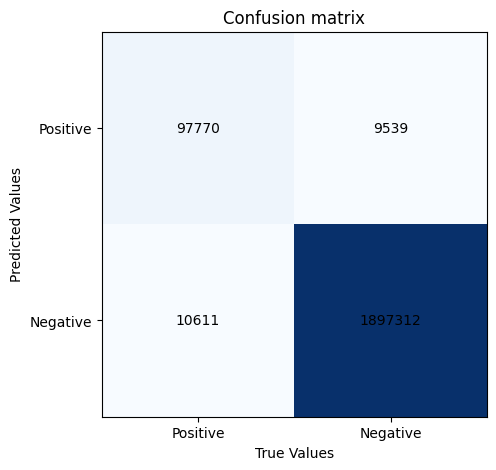

In [18]:
def plot_confusion_matrix(tp, tn, fp, fn):
    # Create the confusion matrix
    confusion_matrix = np.array([[tp, fp], [fn, tn]])

    # Configure the graph
    fig, ax = plt.subplots(figsize = (5, 5), dpi = 100)
    im = ax.imshow(confusion_matrix, cmap='Blues')

    # Añadir etiquetas a los ejes
    ax.set_xticks(np.arange(2))
    ax.set_yticks(np.arange(2))
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['Positive', 'Negative'])

    # Añadir valores a las celdas
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, confusion_matrix[i, j],
                           ha='center', va='center', color='black')

    # Añadir título y etiquetas
    ax.set_title('Confusion matrix')
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')

    # Mostrar el gráfico
    plt.show()


plot_confusion_matrix(tp, tn, fp, fn)

### Metric charts

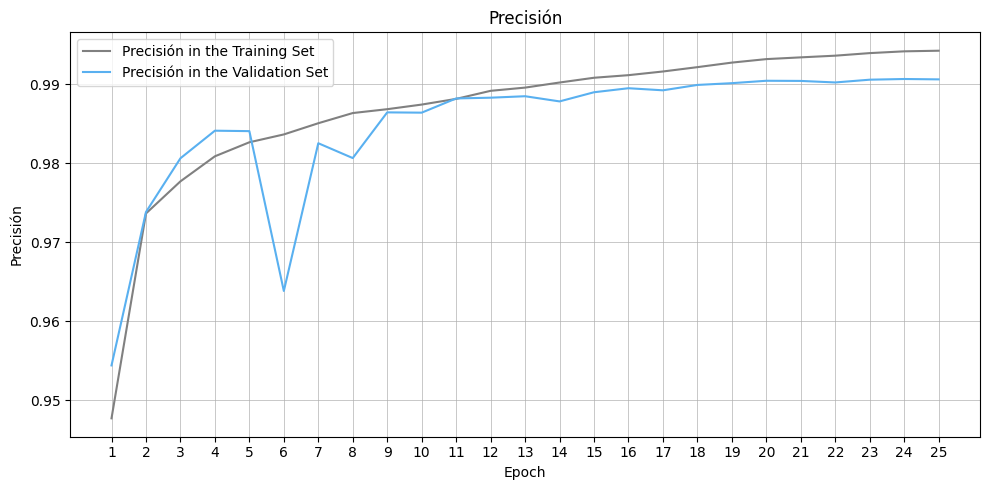

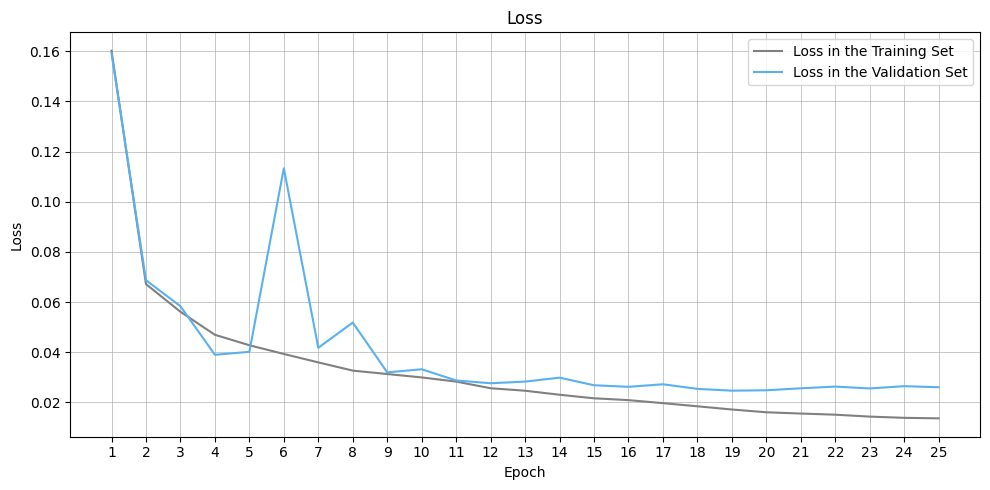

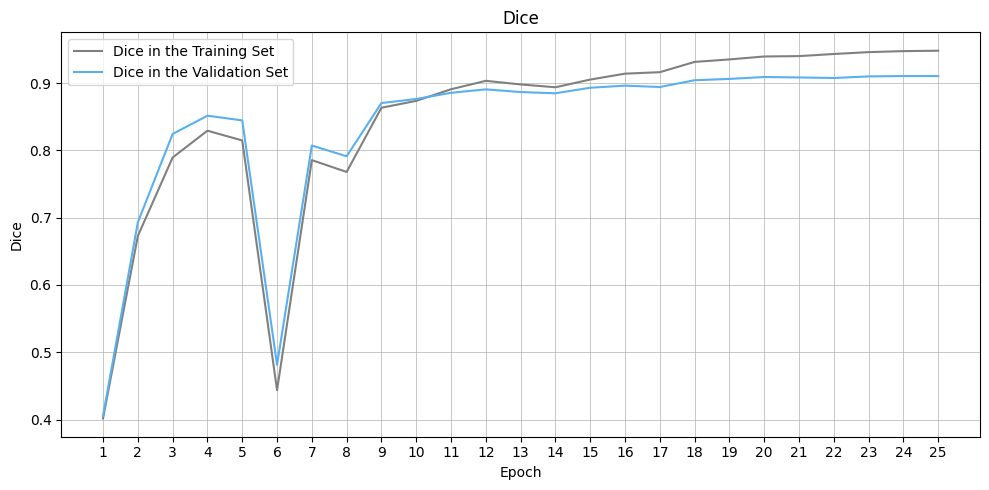

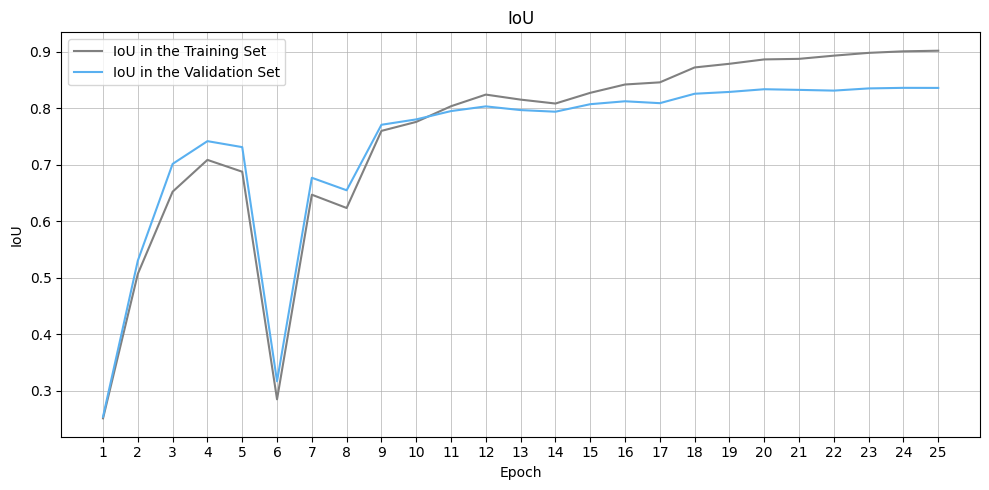

In [19]:
def plot_metrics(history_df, train_label, val_label, y_label, title):
    plt.figure(figsize=(10, 5), dpi = 100)
    plt.plot(history_df["epoch"], history_df[train_label], linestyle='-', color='gray', label=f"{y_label} in the Training Set")
    plt.plot(history_df["epoch"], history_df[val_label], linestyle='-', color='#59B0F0', label=f"{y_label} in the Validation Set")
    plt.xlabel('Epoch')
    plt.ylabel(y_label)
    plt.xticks(history_df["epoch"])
    plt.title(title)
    plt.grid(True, linestyle='-', linewidth=0.7, alpha=0.7)
    plt.tight_layout()
    plt.legend()
    plt.show()

plot_metrics(history_df, "train_acc", "val_acc", "Precisión", "Precisión")
plot_metrics(history_df, "train_cost", "val_cost", "Loss", "Loss")
plot_metrics(history_df, "train_dice", "val_dice", "Dice", "Dice")
plot_metrics(history_df, "train_iou", "val_iou", "IoU", "IoU")

### Plot some images (validation)

In [20]:
def plot_mini_batch_two(imgs, masks, preds, color_pred, color_true):
    plt.figure(figsize=(20, 10))
    for i in range(batch_size):
        plt.subplot(4, 8, i + 1)
        img = imgs[i, ...].permute(1, 2, 0).numpy()
        mask = masks[i, ...].permute(1, 2, 0).numpy()
        pred = preds[i, ...].permute(1, 2, 0).numpy()

        # Adjust image values to valid range [0, 1]
        img = np.clip(img, 0, 1)

        # Get the contour of the prediction mask
        pred_contour_mask = cv2.Canny(pred[:, :, 0].astype(np.uint8), 0, 1)
        img_with_pred_contour = img.copy()
        img_with_pred_contour[pred_contour_mask > 0] = color_pred  # Paint the outline with the prediction color

        # Get the contour of the true data mask
        true_contour_mask = cv2.Canny(mask[:, :, 0].astype(np.uint8), 0, 1)
        img_with_true_contour = img_with_pred_contour.copy()
        img_with_true_contour[true_contour_mask > 0] = color_true  # Paint the outline with the color of the real data

        plt.imshow(img_with_true_contour)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

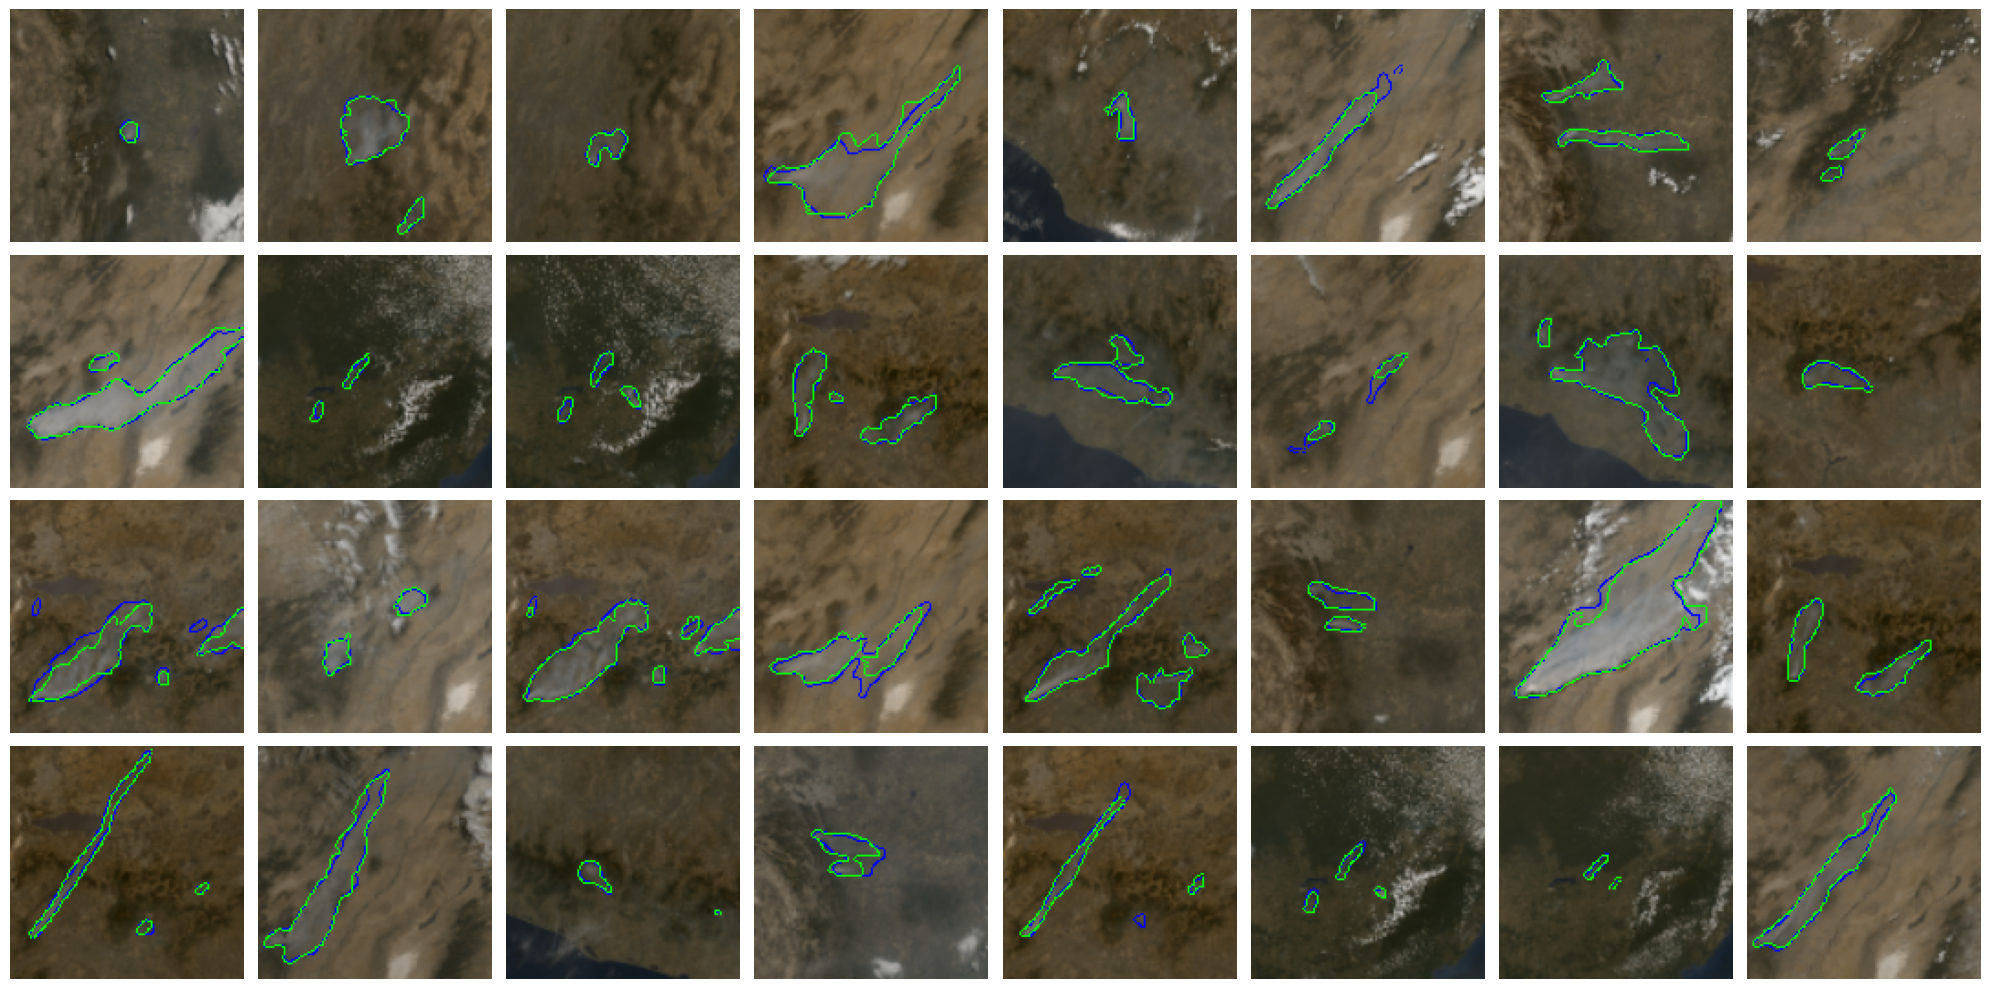

In [21]:
# Code to display the prediction and the true data together
imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_val)
    preds = torch.argmax(scores, dim=1).float()

imgs_val = imgs_val.cpu()
preds = preds.cpu()

plot_mini_batch_two(imgs_val, masks_val, preds.unsqueeze(1), [0, 0, 1], [0, 1, 0])

### Plot some images (test)

In [22]:
def plot_mini_batch_two(imgs, masks, preds, color_pred, color_true):
    plt.figure(figsize=(10, 13), dpi=300)
    for i in range(20):
        plt.subplot(5, 4, i + 1)
        img = imgs[i, ...].permute(1, 2, 0).numpy()
        mask = masks[i, ...].permute(1, 2, 0).numpy()
        pred = preds[i, ...].permute(1, 2, 0).numpy()

        # Adjust image values ​​to valid range [0, 1]
        img = np.clip(img, 0, 1)

        # Get the contour of the true data mask
        true_contour_mask = cv2.Canny(mask[:, :, 0].astype(np.uint8), 0, 1)
        img_with_true_contour = img.copy()
        img_with_true_contour[true_contour_mask > 0] = color_true  # Pintar el contorno con el color del dato verdadero

        # Get the contour of the prediction mask
        pred_contour_mask = cv2.Canny(pred[:, :, 0].astype(np.uint8), 0, 1)
        img_with_pred_contour = img_with_true_contour.copy()
        img_with_pred_contour[pred_contour_mask > 0] = color_pred  # Pintar el contorno con el color de la predicción


        plt.imshow(img_with_pred_contour)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

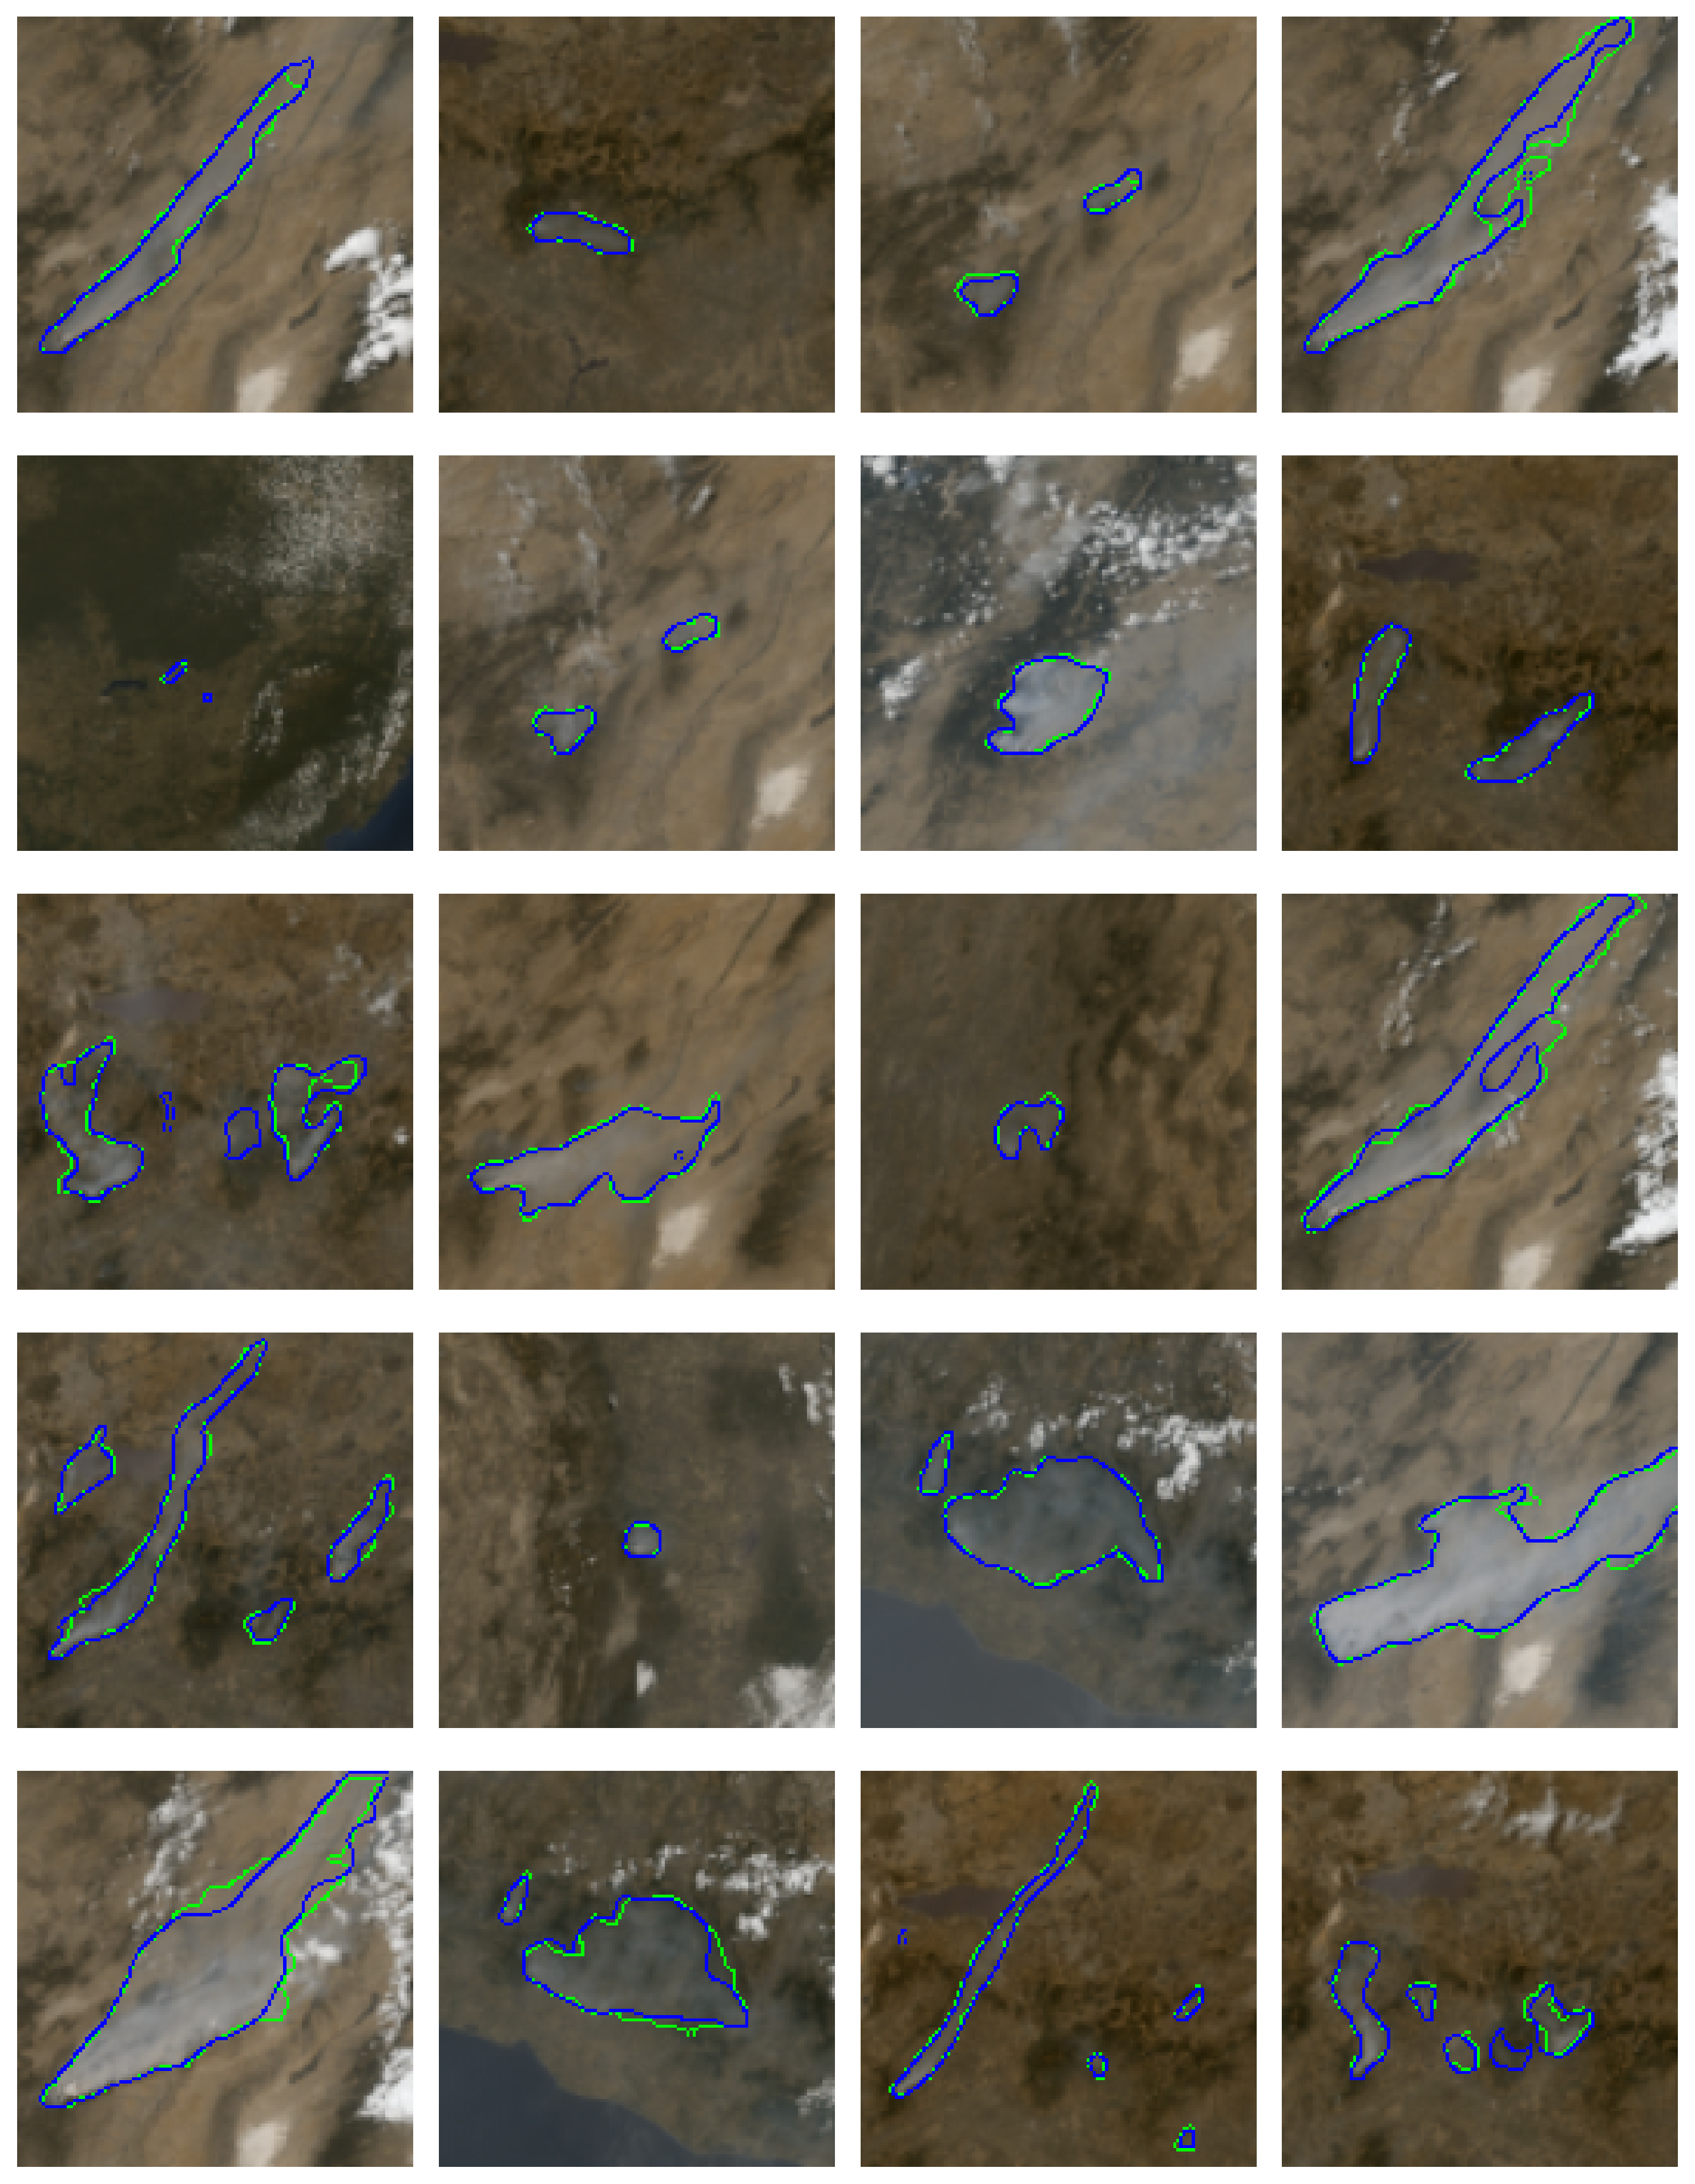

In [23]:
imgs_test, masks_test = next(iter(test_loader))
imgs_test = imgs_test.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_test)
    preds = torch.argmax(scores, dim=1).float()

imgs_test = imgs_test.cpu()
preds = preds.cpu()
#print(preds.shape)
plot_mini_batch_two(imgs_test, masks_test, preds.unsqueeze(1),[0, 0, 1], [0, 1, 0])

### Export model

In [24]:
torch.save(model.state_dict(), models_path + '/smokeUnet_v1_iou8291.pth')